In [1]:
import sys
sys.path.append("/Users/ZRC")
sys.path

['/Users/ZRC/miniconda3/envs/tryit/lib/python36.zip',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/lib-dynload',
 '',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages',
 '/Users/ZRC/miniconda3/envs/tryit/lib/python3.6/site-packages/IPython/extensions',
 '/Users/ZRC/.ipython',
 '/Users/ZRC']

In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler


from torchvision import datasets
from torchvision import transforms

from torchsummary import summary

In [95]:
from coke.visualization.image import show_batch
from coke.models.customized_metrics import compute_accuracy

In [48]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

## Setting

In [113]:
# Hyperparameters
batch_size = 64
num_features = 28 * 28
learning_rate = 0.1
random_seed = 7
num_epochs = 3
DROP_OUT_PROB = 0.5


# Architecture
HIDDEN_NUMS_1 = 128
HIDDEN_NUMS_2 = 256
num_classes = 10

In [83]:
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

In [84]:
train_dataset = datasets.MNIST(root = "data", 
                               train = True, 
                               transform= data_transforms["train"], 
                               download= True )

val_dataset = datasets.MNIST(root = "data", 
                               train = False, 
                               transform= data_transforms["val"], 
                               ) 

train_loader = DataLoader(dataset = train_dataset, 
                          batch_size=batch_size, 
                          shuffle= True)

val_loader = DataLoader(dataset = val_dataset,
                         batch_size=batch_size,
                         shuffle= False)

data_loader = {"train": train_loader, "val": val_loader}

In [85]:
inputs, classes = next(iter(data_loader["train"]))

In [86]:
inputs.size(), classes.size()

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

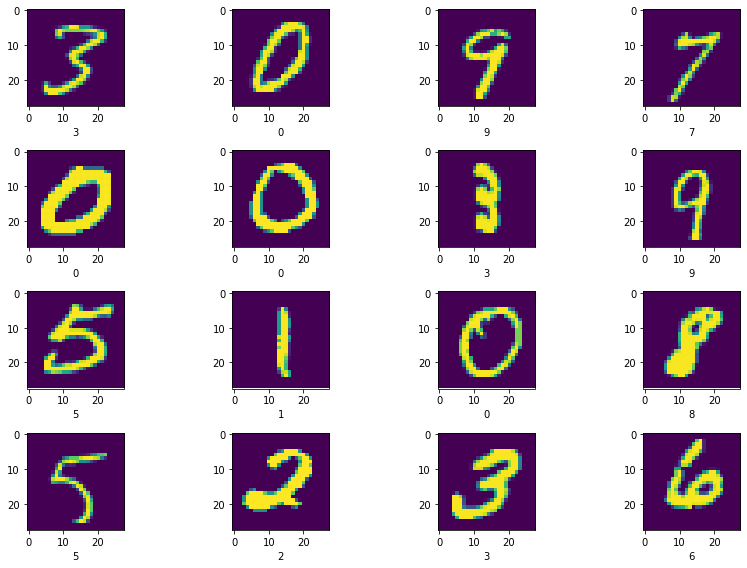

In [87]:
show_batch(inputs.squeeze().numpy(),classes.numpy(),(4,4))

In [114]:
def init_weights(layer):
    if type(layer) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(layer.weight)
#         torch.nn.init.normal_(layer.weight, 0.0, 0.1)
        torch.nn.init.constant_(layer.bias.data, 0)

## Model

In [115]:
class MultilayerPerceptronZrc(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(MultilayerPerceptronZrc,self).__init__()
        
        self.f1 = torch.nn.Linear(num_features,HIDDEN_NUMS_1)
        self.f2 = torch.nn.Linear(HIDDEN_NUMS_1,HIDDEN_NUMS_2)
        self.f_out = torch.nn.Linear(HIDDEN_NUMS_2, num_classes)
        self.drop_1 = torch.nn.Dropout(p = DROP_OUT_PROB)
        self.drop_2 = torch.nn.Dropout(p = DROP_OUT_PROB)
    
    def forward(self,x):
        x = self.f1(x)
        x = F.relu(x)
        x = self.drop_1(x)
        
        x = self.f2(x)
        x = F.relu(x)
        x = self.drop_2(x)
        
        logits = self.f_out(x)
        probas = F.softmax(logits, dim = 1)
        
        return logits, probas 
    
    
model = MultilayerPerceptronZrc(num_features= num_features, 
                              num_classes = num_classes)
model.apply(init_weights)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [116]:
summary(model, (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
           Dropout-2                  [-1, 128]               0
            Linear-3                  [-1, 256]          33,024
           Dropout-4                  [-1, 256]               0
            Linear-5                   [-1, 10]           2,570
Total params: 136,074
Trainable params: 136,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.52
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


In [117]:
def train_model(model, data_loader, optimizer, num_epochs, metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    for epoch in range(num_epochs):
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.view(-1, num_features).to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            if not batch_idx % 50:
                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.2f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss))

        with torch.set_grad_enabled(False):
            print('Epoch: {0:03d}/{1:03d} training accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, 
                  metric_func(model, data_loader["train"], device)))
            
            print('Epoch: {0:03d}/{1:03d} training accuracy: {2:.2f}'.format(
                  epoch+1, num_epochs, 
                  metric_func(model, data_loader["val"], device)))

In [118]:
train_model(model, data_loader, optimizer, num_epochs, metric_func = compute_accuracy)

Epoch: 001/003 | Batch 000/937 | Loss: 2.30
Epoch: 001/003 | Batch 050/937 | Loss: 1.26
Epoch: 001/003 | Batch 100/937 | Loss: 0.87
Epoch: 001/003 | Batch 150/937 | Loss: 0.60
Epoch: 001/003 | Batch 200/937 | Loss: 0.63
Epoch: 001/003 | Batch 250/937 | Loss: 0.61
Epoch: 001/003 | Batch 300/937 | Loss: 0.61
Epoch: 001/003 | Batch 350/937 | Loss: 0.69
Epoch: 001/003 | Batch 400/937 | Loss: 0.61
Epoch: 001/003 | Batch 450/937 | Loss: 0.52
Epoch: 001/003 | Batch 500/937 | Loss: 0.44
Epoch: 001/003 | Batch 550/937 | Loss: 0.42
Epoch: 001/003 | Batch 600/937 | Loss: 0.39
Epoch: 001/003 | Batch 650/937 | Loss: 0.26
Epoch: 001/003 | Batch 700/937 | Loss: 0.27
Epoch: 001/003 | Batch 750/937 | Loss: 0.27
Epoch: 001/003 | Batch 800/937 | Loss: 0.38
Epoch: 001/003 | Batch 850/937 | Loss: 0.24
Epoch: 001/003 | Batch 900/937 | Loss: 0.40
Epoch: 001/003 training accuracy: 0.93
Epoch: 001/003 training accuracy: 0.94
Epoch: 002/003 | Batch 000/937 | Loss: 0.40
Epoch: 002/003 | Batch 050/937 | Loss: 0.5